In [1]:
import numpy as np
import pandas as pd
import requests
import os
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import re
import json
from sklearn.linear_model import Ridge
import xgboost as xgb
import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap
from sklearn.neighbors import KNeighborsRegressor

# Data Preprocessing and Feature Engineering

In [ ]:
raw_data = pd.read_csv("raw_data.csv")

In [5]:
# Xem xét các giá trị trong Dataframe
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Link                   10050 non-null  object
 1   Diện tich              9032 non-null   object
 2   Phòng WC               5815 non-null   object
 3   Phòng ngủ              6125 non-null   object
 4   Giá                    10050 non-null  object
 5   Hướng nhà              1021 non-null   object
 6   Hướng ban công         513 non-null    object
 7   Mô tả                  10050 non-null  object
 8   Giờ đăng               10050 non-null  object
 9   Ngày đăng              10050 non-null  object
 10  Quận                   10050 non-null  object
 11  Loại nhà               10050 non-null  object
 12  des                    10050 non-null  object
 13  Diện tích              9400 non-null   object
 14  Số phòng ngủ           7610 non-null   object
 15  Số wc              

In [7]:
# Hàm làm sạch dữ liệu diện tích
def clean_area(area_str):
    # if isinstance(area_str,(int,float)):
    #     return area_str
    if isinstance(area_str, str):
        match = re.match(r'(\d+)\s?m2', area_str.strip(), re.IGNORECASE)
        if match:
            return float(match.group(1))
    return None
# Hàm làm sạch dữ liệu PN
def clean_PN(PN_str):
    if isinstance(PN_str, str):
        match = re.match(r'(\d+)\s?PN', PN_str.strip(), re.IGNORECASE)
        if match:
            return int(match.group(1))
    return None
# Hàm làm sạch dữ liệu WC
def clean_WC(WC_str):
    if isinstance(WC_str, str):
        match = re.match(r'(\d+)\s?WC', WC_str.strip(), re.IGNORECASE)
        if match:
            return int(match.group(1))
    return None
# Hàm làm sạch dữ liệu Giá
def clean_price(price_str):
    if isinstance(price_str, str):
        # Sử dụng regex để trích xuất phần số (có thể bao gồm phần thập phân) trước từ "tỷ"
        match = re.match(r'(\d+(\.\d+)?)\s?tỷ', price_str.strip(), re.IGNORECASE)
        if match:
            # Trả về phần số dưới dạng float
            return float(match.group(1))
    return None
# Hàm chia ngày/tháng/năm
def split_date(date_str):
    if isinstance(date_str, str):
        match = re.match(r'(\d{2})/(\d{2})/(\d{4})', date_str.strip())
        if match:
            day, month, year = match.groups()
            return int(day), int(month), int(year)
    return None, None, None


In [9]:
# Áp dụng các hàm đã xây dựng vào dữ liệu
raw_data['Diện tich'] = raw_data['Diện tich'].apply(clean_area)
raw_data['Diện tích'] = raw_data['Diện tích'].apply(clean_area)
raw_data['Phòng ngủ'] = raw_data['Phòng ngủ'].apply(clean_PN)
raw_data['Phòng WC'] = raw_data['Phòng WC'].apply(clean_WC)
raw_data['Giá'] = raw_data['Giá'].apply(clean_price)
raw_data['Giá tiền'] = raw_data['Giá tiền'].apply(clean_price)
raw_data['Day'], raw_data['Month'], raw_data['Year'] = zip(*raw_data['Ngày đăng '].apply(split_date))

In [11]:
# Ta sẽ điền các giá trị null bên trái bằng các giá trị bên phải (Nếu có)
raw_data['Area'] = raw_data['Diện tich'].fillna(raw_data['Diện tích'])
raw_data['WC'] = raw_data['Phòng WC'].fillna(raw_data['Số wc'])
raw_data['PN'] = raw_data['Phòng ngủ'].fillna(raw_data['Số phòng ngủ'])
raw_data['Price'] = raw_data['Giá'].fillna(raw_data['Giá tiền'])
# Đổi tên một số thuộc tính
raw_data['Floor'] = raw_data['Số tầng']
raw_data['SoSach'] = raw_data['Sổ hồng/sổ đỏ/pháp lý']
raw_data['district'] = raw_data['Quận']
raw_data['Type'] = raw_data['Loại nhà']
# Drop các thuộc tính bên phải đi
columns_to_drop = ['Link', 'Diện tich', 'Phòng WC', 'Phòng ngủ', 'Giá', 'Hướng nhà',
       'Hướng ban công', 'Mô tả ', 'Giờ đăng', 'Quận',
       'Loại nhà', 'des', 'Diện tích', 'Số phòng ngủ',
       'Số wc', 'Số tầng','Ngày đăng ', 'Sổ hồng/sổ đỏ/pháp lý', 'Giá tiền']

raw_data.drop(columns=columns_to_drop, inplace=True)

In [13]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Day       10050 non-null  int64  
 1   Month     10050 non-null  int64  
 2   Year      10050 non-null  int64  
 3   Area      9509 non-null   float64
 4   WC        7894 non-null   object 
 5   PN        8732 non-null   object 
 6   Price     9696 non-null   float64
 7   Floor     9681 non-null   object 
 8   SoSach    9673 non-null   object 
 9   district  10050 non-null  object 
 10  Type      10050 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 863.8+ KB


In [15]:
# Chuyển đổi cột 'Floor' thành dạng số và đặt các giá trị không thể chuyển đổi thành Null
raw_data['Floor'] = pd.to_numeric(raw_data['Floor'], errors='coerce')
# Chuyển đổi cột 'WC' thành dạng số và đặt các giá trị không thể chuyển đổi thành Null
raw_data['WC'] = pd.to_numeric(raw_data['WC'], errors='coerce')
# Chuyển đổi cột 'PN' thành dạng số và đặt các giá trị không thể chuyển đổi thành Null
raw_data['PN'] = pd.to_numeric(raw_data['PN'], errors='coerce')

In [17]:
# Note
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Day       10050 non-null  int64  
 1   Month     10050 non-null  int64  
 2   Year      10050 non-null  int64  
 3   Area      9509 non-null   float64
 4   WC        7866 non-null   float64
 5   PN        8704 non-null   float64
 6   Price     9696 non-null   float64
 7   Floor     9675 non-null   float64
 8   SoSach    9673 non-null   object 
 9   district  10050 non-null  object 
 10  Type      10050 non-null  object 
dtypes: float64(5), int64(3), object(3)
memory usage: 863.8+ KB


In [19]:
# Xem xét xử lý các giá trị null của thuộc tính Categorical
raw_data['SoSach'].unique()

array(['Có', nan, ' Có', 'Co/Khong', 'Có/Không', 'Đang vay ngân hàng',
       'Không', 'Co', 'Sổ đỏ', 'Riêng, Vuông Vức', 'Tr钏o tay',
       'Sổ hồng riêng', 'Pháp lý chuẩn', 'Sổ chung', 'Sổ vuông A4'],
      dtype=object)

In [21]:
# # Chỉ giữ lại các giá trị "Có", "Không", còn lại trả về null
raw_data['SoSach'] = raw_data['SoSach'].map(lambda x: x if x in ['Có', 'Không'] else np.nan)
raw_data['SoSach'] = raw_data['SoSach'].fillna('Unknown')

In [23]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Day       10050 non-null  int64  
 1   Month     10050 non-null  int64  
 2   Year      10050 non-null  int64  
 3   Area      9509 non-null   float64
 4   WC        7866 non-null   float64
 5   PN        8704 non-null   float64
 6   Price     9696 non-null   float64
 7   Floor     9675 non-null   float64
 8   SoSach    10050 non-null  object 
 9   district  10050 non-null  object 
 10  Type      10050 non-null  object 
dtypes: float64(5), int64(3), object(3)
memory usage: 863.8+ KB


In [25]:
# Xử lý Duplicate
raw_data = raw_data.drop_duplicates()

In [27]:
# Xử lý các Outlier

# Format Giá về đúng đơn vị
raw_data.loc[raw_data['Price'] > 1_000_000_000, 'Price'] /= 1_000_000_000
raw_data.loc[raw_data['Price'] > 1_000_000, 'Price'] /= 1_000_000
raw_data.loc[raw_data['Price'] > 1_000, 'Price'] /= 1_000
raw_data.loc[raw_data['Price'] > 500, 'Price'] /= 100
raw_data = raw_data[raw_data['Price'] > 0]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9171 entries, 0 to 10049
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Day       9171 non-null   int64  
 1   Month     9171 non-null   int64  
 2   Year      9171 non-null   int64  
 3   Area      8776 non-null   float64
 4   WC        7233 non-null   float64
 5   PN        8002 non-null   float64
 6   Price     9171 non-null   float64
 7   Floor     8841 non-null   float64
 8   SoSach    9171 non-null   object 
 9   district  9171 non-null   object 
 10  Type      9171 non-null   object 
dtypes: float64(5), int64(3), object(3)
memory usage: 859.8+ KB


In [29]:
raw_data.describe()

,Day,Month,Year,Area,WC,PN,Price,Floor
count,9171.000000,9171.000000,9171.000000,8776.000000,7233.00000,8002.000000,9171.000000,8841.000000
mean,15.666994,7.642787,2022.762403,84.591841,3.41518,3.655086,11.072697,2.712872
std,8.905422,3.355325,0.425634,375.618768,3.58251,3.698452,28.335849,1.264369
min,1.000000,1.000000,2022.000000,5.000000,0.00000,0.000000,0.500000,1.000000
25%,8.000000,5.000000,2023.000000,45.000000,2.00000,2.000000,4.200000,2.000000
50%,16.000000,8.000000,2023.000000,60.000000,3.00000,3.000000,5.900000,3.000000
75%,24.000000,11.000000,2023.000000,84.000000,4.00000,4.000000,9.300000,3.000000
max,31.000000,12.000000,2023.000000,32825.000000,127.00000,127.000000,500.000000,12.000000


In [31]:
# Dùng Percentile để giới hạn dữ liệu với các mức cho trước
col = ('WC','PN','Area')
# Giới hạn Price ở mức 90%
up_limit = raw_data.Price.quantile(0.9)
print("Price Percentile Vale:",up_limit)
new_raw_data = raw_data.loc[((raw_data.Price<up_limit)&(raw_data.Price!=0.0))|raw_data.Price.isna()]
for i in col:
    # Giới hạn các thuộc tính khác ở mức 97%
  up_limit = new_raw_data[i].quantile(0.97)
  print(i,"Percentile Vale:",up_limit)
  new_raw_data = new_raw_data.loc[((new_raw_data[i]<up_limit)&new_raw_data[i]!=0.0)|new_raw_data[i].isna()]

Price Percentile Vale: 18.5
WC Percentile Vale: 7.0
PN Percentile Vale: 6.0
Area Percentile Vale: 152.0


In [33]:
new_raw_data.describe()

,Day,Month,Year,Area,WC,PN,Price,Floor
count,7436.000000,7436.000000,7436.000000,7121.000000,6060.000000,6638.000000,7436.000000,7143.000000
mean,15.613098,7.705083,2022.743948,60.326640,2.894389,3.034197,5.917690,2.565099
std,8.953184,3.372507,0.436480,25.253964,1.210234,1.035110,3.083556,1.089764
min,1.000000,1.000000,2022.000000,5.000000,1.000000,1.000000,0.500000,1.000000
25%,8.000000,5.000000,2022.000000,43.000000,2.000000,2.000000,3.900000,2.000000
50%,15.000000,8.000000,2023.000000,56.000000,3.000000,3.000000,5.250000,2.000000
75%,24.000000,11.000000,2023.000000,72.000000,4.000000,4.000000,7.100000,3.000000
max,31.000000,12.000000,2023.000000,151.000000,6.000000,5.000000,18.100000,8.000000


In [35]:
# Hàm điền các giá trị NULL sử dụng K-Nearest Neighbors
def impute_knn(df):
    # Chia Dataframe thành dạng số và dạng phân loại
    num_df = df.select_dtypes(include=[np.number])           # Chọn các cột dạng số trong Df
    non_num_df = df.select_dtypes(exclude=[np.number])  # Chọn các cột dạng phân loại hoặc không phải số trong Df
    # Chọn các cột có và không có missing value
    null_cols = num_df.columns[num_df.isna().any()].tolist()         # Chọn các cột có chứa giá trị Null
    cols = num_df.columns.difference(null_cols).values     # Các cột không có giá trị Null 

    for col in null_cols:                
        imp_test = num_df[num_df[col].isna()]   # Chọn các dòng có giá trị Null trở thành tập Test
        imp_train = num_df.dropna()          # chọn các dòng không có giá trị Null là tập Train 
        model = KNeighborsRegressor(n_neighbors=3)  # Áp dụng KNN
        knr = model.fit(imp_train[cols], imp_train[col]) # Huấn luyện mô hình
        num_df.loc[df[col].isna(), col] = knr.predict(imp_test[cols]) # Thay thế các giá trị Null bằng các giá trị dự đoán được của mô hình
    # Trả về Dataframe tổng hợp giữa các cột dạng số vừa xử lý và các cột dạng phân loại ban đầu
    return pd.concat([num_df,non_num_df],axis=1)

clean_data = impute_knn(new_raw_data)
clean_data.describe()

,Day,Month,Year,Area,WC,PN,Price,Floor
count,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000
mean,15.613098,7.705083,2022.743948,60.276851,2.897615,3.038372,5.917690,2.569146
std,8.953184,3.372507,0.436480,25.111097,1.157715,1.010262,3.083556,1.078516
min,1.000000,1.000000,2022.000000,5.000000,1.000000,1.000000,0.500000,1.000000
25%,8.000000,5.000000,2022.000000,43.000000,2.000000,2.000000,3.900000,2.000000
50%,15.000000,8.000000,2023.000000,55.666667,3.000000,3.000000,5.250000,2.000000
75%,24.000000,11.000000,2023.000000,72.000000,4.000000,4.000000,7.100000,3.000000
max,31.000000,12.000000,2023.000000,151.000000,6.000000,5.000000,18.100000,8.000000


In [37]:
clean_data.describe()

,Day,Month,Year,Area,WC,PN,Price,Floor
count,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000
mean,15.613098,7.705083,2022.743948,60.276851,2.897615,3.038372,5.917690,2.569146
std,8.953184,3.372507,0.436480,25.111097,1.157715,1.010262,3.083556,1.078516
min,1.000000,1.000000,2022.000000,5.000000,1.000000,1.000000,0.500000,1.000000
25%,8.000000,5.000000,2022.000000,43.000000,2.000000,2.000000,3.900000,2.000000
50%,15.000000,8.000000,2023.000000,55.666667,3.000000,3.000000,5.250000,2.000000
75%,24.000000,11.000000,2023.000000,72.000000,4.000000,4.000000,7.100000,3.000000
max,31.000000,12.000000,2023.000000,151.000000,6.000000,5.000000,18.100000,8.000000


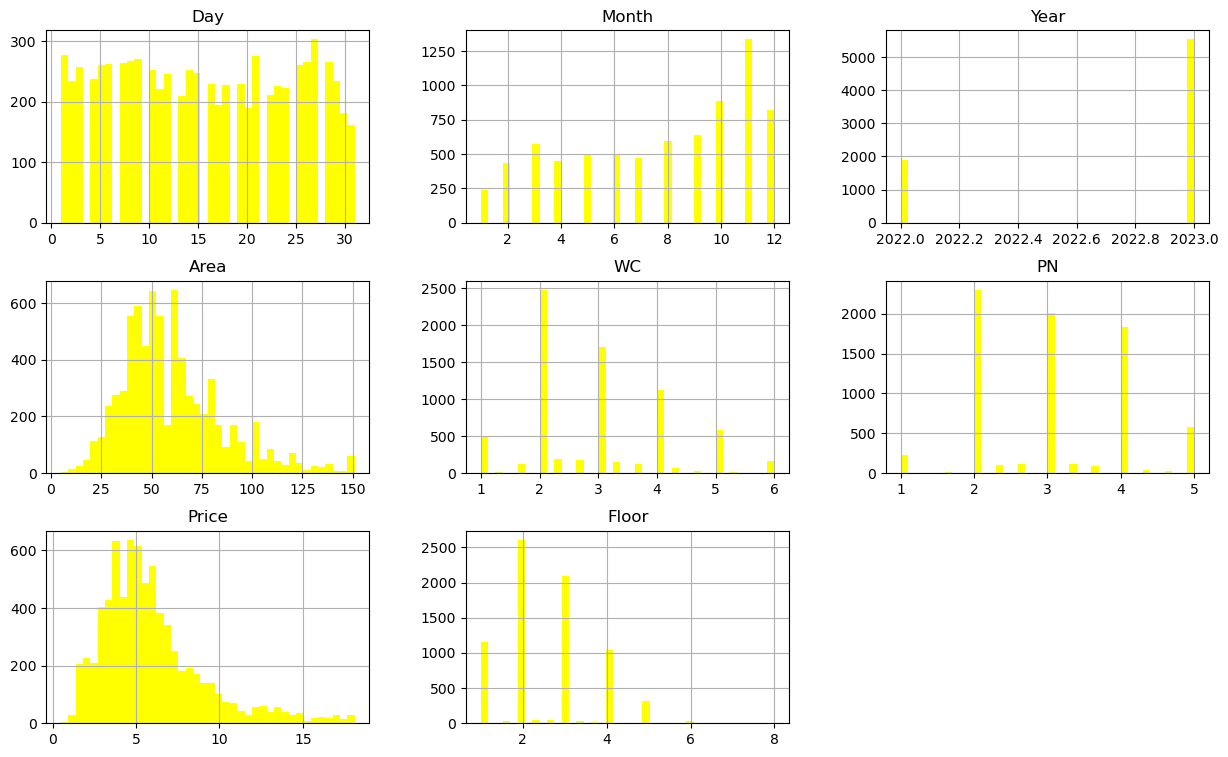

In [39]:
# Biểu đồ Histogram biểu diễn phân bố của từng thuộc tính
clean_data.hist(bins=40, figsize=(15,9),color="yellow");plt.show()

In [41]:
clean_data

,Day,Month,Year,Area,WC,PN,Price,Floor,SoSach,district,Type
0,10,12,2023,150.0,1.0,2.000000,3.899,1.0,Có,Nhà Bè,Bán Nhà riêng
1,10,12,2023,51.0,2.0,2.666667,5.500,3.0,Có,Tân Bình,Bán Nhà riêng
2,10,12,2023,45.0,2.0,2.000000,4.600,2.0,Có,Phú Nhuận,Bán Nhà
3,10,12,2023,41.0,4.0,4.000000,7.350,2.0,Có,Quận 5,Bán Nhà riêng
5,8,12,2023,91.0,3.0,3.000000,3.500,3.0,Có,Thủ Đức,Bán Nhà mặt phố
...,...,...,...,...,...,...,...,...,...,...,...
10045,25,10,2022,60.0,3.0,3.000000,5.400,3.0,Có,Tân Phú,Bán Nhà riêng
10046,25,10,2022,60.0,1.0,4.000000,7.930,5.0,Có,Gò Vấp,Bán Nhà riêng
10047,25,10,2022,100.0,3.0,4.000000,6.000,1.0,Có,Thủ Đức,Bán Nhà riêng
10048,22,10,2022,52.0,2.0,3.000000,3.480,2.0,Có,Quận 12,Bán Nhà riêng


In [43]:
# Xử lý các giá trị Categorical bằng Target Encoding
# Do Thuộc tính "Vị trí" không có phân mức "Cao","Trung bình",... và có nhiều giá trị khác nhau (Quận 1, Quận 2, Thủ Đức,...) nên ta sẽ dùng
# Target Encoding thay vì One Hot Encoding hay Label Encoding
clean_data['HouseType'] = clean_data.groupby("Type")["Price"].transform("mean")
clean_data['Location'] = clean_data.groupby("district")["Price"].transform("mean")
clean_data['Legal'] = clean_data.groupby("SoSach")["Price"].transform("mean")

clean_data.describe()

,Day,Month,Year,Area,WC,PN,Price,Floor,HouseType,Location,Legal
count,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000,7436.000000
mean,15.613098,7.705083,2022.743948,60.276851,2.897615,3.038372,5.917690,2.569146,5.917690,5.917690,5.917690
std,8.953184,3.372507,0.436480,25.111097,1.157715,1.010262,3.083556,1.078516,0.813969,0.812238,0.081487
min,1.000000,1.000000,2022.000000,5.000000,1.000000,1.000000,0.500000,1.000000,5.543709,4.220345,4.698889
25%,8.000000,5.000000,2022.000000,43.000000,2.000000,2.000000,3.900000,2.000000,5.543709,5.431105,5.908899
50%,15.000000,8.000000,2023.000000,55.666667,3.000000,3.000000,5.250000,2.000000,5.543709,5.831480,5.908899
75%,24.000000,11.000000,2023.000000,72.000000,4.000000,4.000000,7.100000,3.000000,5.543709,6.308395,5.908899
max,31.000000,12.000000,2023.000000,151.000000,6.000000,5.000000,18.100000,8.000000,11.714516,8.821571,6.179562


In [45]:
# Xóa đi các thuộc tính phân loại (đã được chuyển đổi)
cleaned_data = clean_data.drop(['Type','district','SoSach'],axis = 1)
cleaned_data

,Day,Month,Year,Area,WC,PN,Price,Floor,HouseType,Location,Legal
0,10,12,2023,150.0,1.0,2.000000,3.899,1.0,5.543709,6.356913,5.908899
1,10,12,2023,51.0,2.0,2.666667,5.500,3.0,5.543709,6.305352,5.908899
2,10,12,2023,45.0,2.0,2.000000,4.600,2.0,6.589457,7.197768,5.908899
3,10,12,2023,41.0,4.0,4.000000,7.350,2.0,5.543709,6.913571,5.908899
5,8,12,2023,91.0,3.0,3.000000,3.500,3.0,7.485201,5.583662,5.908899
...,...,...,...,...,...,...,...,...,...,...,...
10045,25,10,2022,60.0,3.0,3.000000,5.400,3.0,5.543709,5.624838,5.908899
10046,25,10,2022,60.0,1.0,4.000000,7.930,5.0,5.543709,5.831480,5.908899
10047,25,10,2022,100.0,3.0,4.000000,6.000,1.0,5.543709,5.583662,5.908899
10048,22,10,2022,52.0,2.0,3.000000,3.480,2.0,5.543709,4.220345,5.908899


<Axes: >

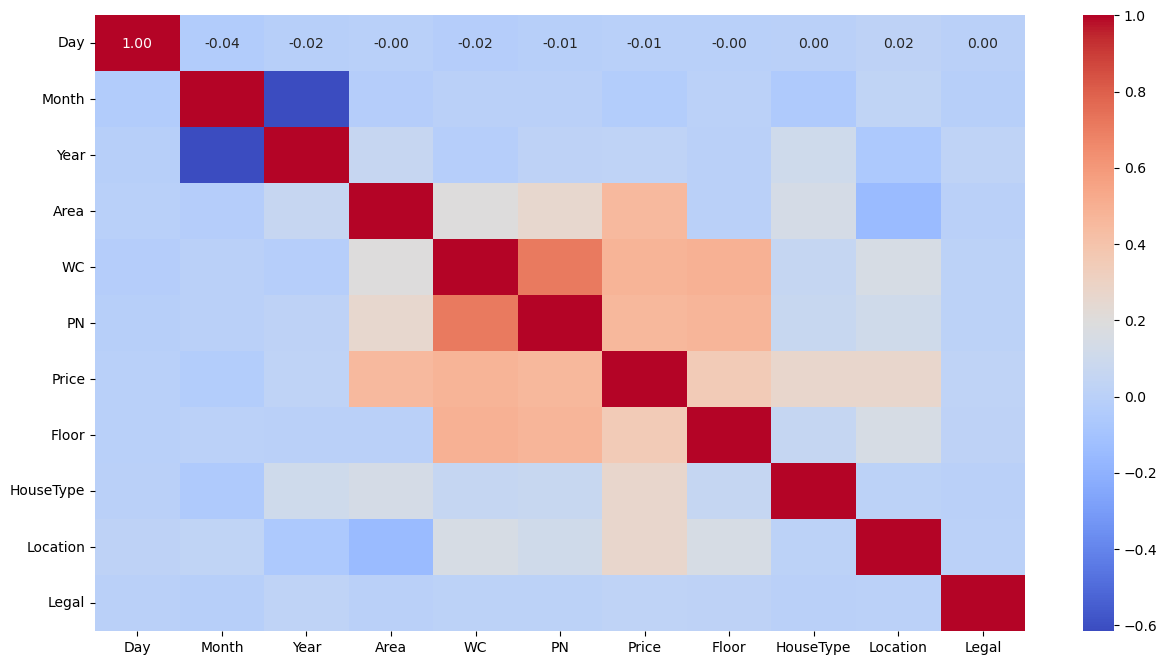

In [47]:
# Heatmap thể hiện Correlation giữa các biến quan sát và biến y
plt.figure(figsize = (15,8))
sns.heatmap(cleaned_data.corr(), annot = True,fmt=".2f", cmap ='coolwarm' )

Nhận xét:
- Biến phụ thuộc Price phụ thuộc tương đối cao các biến "Area", "WC", "PN".
- Các thuộc tính "Floor", "HouseType", "Location" cũng ảnh hưởng tương đối đến y.
- Các thuộc tính "Month", "Year", "Day", "Legal" hầu như không ảnh hưởng đến y.

In [50]:
# DataFrame cuối cùng sau khi loại bỏ các biến quan sát không cần thiết
df = cleaned_data.drop(['Day','Month','Year','Legal'], axis = 1)
df

,Area,WC,PN,Price,Floor,HouseType,Location
0,150.0,1.0,2.000000,3.899,1.0,5.543709,6.356913
1,51.0,2.0,2.666667,5.500,3.0,5.543709,6.305352
2,45.0,2.0,2.000000,4.600,2.0,6.589457,7.197768
3,41.0,4.0,4.000000,7.350,2.0,5.543709,6.913571
5,91.0,3.0,3.000000,3.500,3.0,7.485201,5.583662
...,...,...,...,...,...,...,...
10045,60.0,3.0,3.000000,5.400,3.0,5.543709,5.624838
10046,60.0,1.0,4.000000,7.930,5.0,5.543709,5.831480
10047,100.0,3.0,4.000000,6.000,1.0,5.543709,5.583662
10048,52.0,2.0,3.000000,3.480,2.0,5.543709,4.220345


In [52]:
df.to_csv('D://Năm 2//Hk2//NMKHDL//Project//Dataframe.csv')

<Axes: >

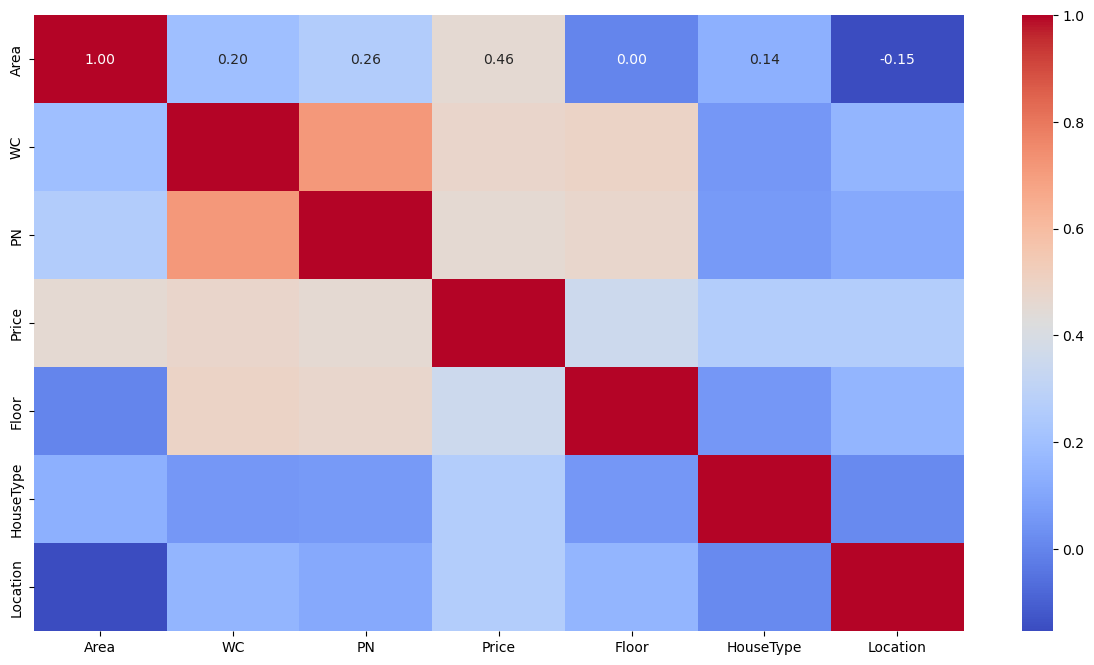

In [54]:
# Biểu đồ Heatmap sau khi đã loại bỏ các thuộc tính không cần thiết
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot = True,fmt=".2f", cmap ='coolwarm' )

# Modeling and Evaluation

In [59]:
# Chia dữ liệu thành tập X (Các biến thuộc tính) và y (Price)
X = df.drop(['Price'],axis = 1) 
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [61]:
# Thực hiện trên mô hình Linear Regression

linear = LinearRegression(fit_intercept=False)
linear.fit(X_train, y_train)
# Đánh giá mô hình
y_test_pred1 = linear.predict(X_test)
mse1 = mean_squared_error(y_test, y_test_pred1)
print(">> R2 Score of Test Data: ",r2_score(y_test,y_test_pred1))
print(">> Mean Squared Error:", mse1)

>> R2 Score of Test Data:  0.40360800047524126
>> Mean Squared Error: 5.6959887273609775


In [63]:
# Thực hiện trên mô hình Ridge Regression

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
# Các thông số đánh giá
y_test_pred2 = ridge_reg.predict(X_test)
mse2 = mean_squared_error(y_test, y_test_pred2)
print(">> R2 Score of Test Data: ",r2_score(y_test,y_test_pred2))
print(">> Mean Squared Error:", mse2)

>> R2 Score of Test Data:  0.49883316092336727
>> Mean Squared Error: 4.786517371430843


In [65]:
# Thực hiện trên mô hình Random Forest Regression

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)
rf_regressor.fit(X_train, y_train)
# Đánh giá mô hình
y_test_pred3 = rf_regressor.predict(X_test)
mse3 = mean_squared_error(y_test, y_test_pred3)
print(">> R2 Score of Test Data: ",r2_score(y_test,y_test_pred3))
print(">> Mean Squared Error:", mse3)


>> R2 Score of Test Data:  0.6102443143403755
>> Mean Squared Error: 3.7224577018322424


In [67]:
# Thực hiện trên mô hình XGBoost

xgbm = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgbm.fit(X_train, y_train)

# Đánh giá mô hình
y_test_pred4 = xgbm.predict(X_test)
mse4 = mean_squared_error(y_test, y_test_pred4)
print(">> R2 Score of Test Data: ",r2_score(y_test,y_test_pred4))
print('>> Mean Squared Error:',mse4)

>> R2 Score of Test Data:  0.6178957102293088
>> Mean Squared Error: 3.6493811602846224


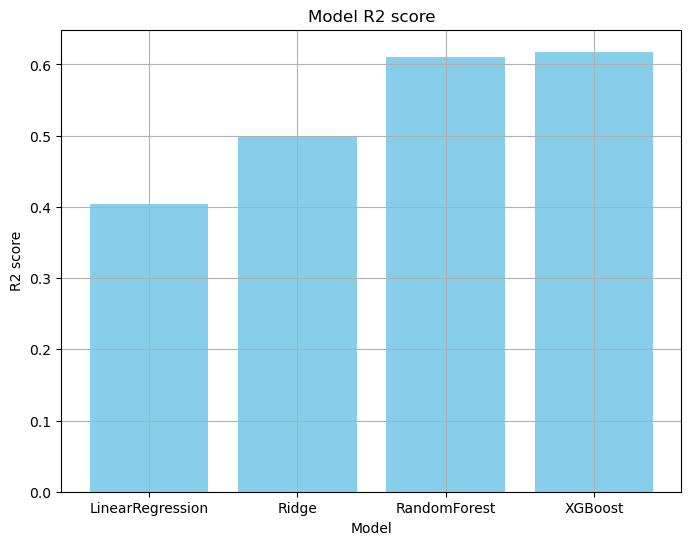

In [69]:
# So sánh R2 Score giữa các mô hình
r2 = [r2_score(y_test,y_test_pred1),r2_score(y_test,y_test_pred2),r2_score(y_test,y_test_pred3),r2_score(y_test,y_test_pred4)]
model = ['LinearRegression','Ridge','RandomForest','XGBoost']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar( model,r2, color='skyblue')
plt.xlabel('Model')
plt.ylabel('R2 score')
plt.title('Model R2 score')
plt.grid(True)
plt.show()


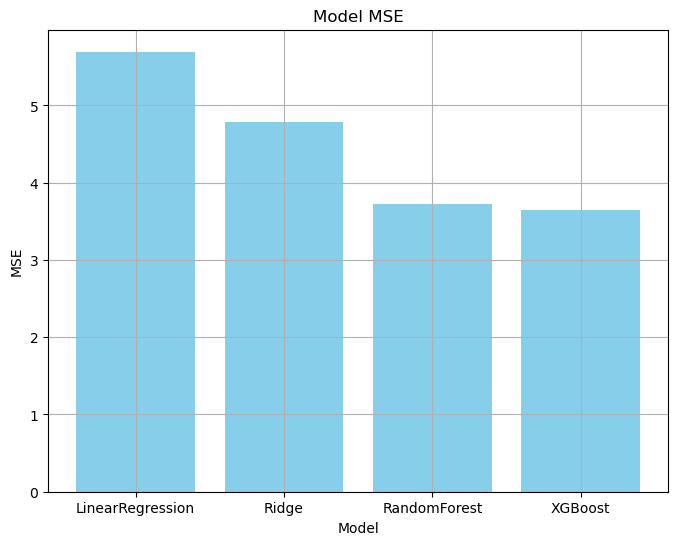

In [72]:
# So sánh MSE giữa các mô hình
mse = [mse1,mse2,mse3,mse4]

plt.figure(figsize=(8, 6))
plt.bar(model,mse, color='skyblue')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model MSE')
plt.grid(True)
plt.show()

# Others...

Vẽ biểu đồ Heatmap thể hiện phân bố số lượng nhà được đăng bán tại khu vực Tp HCM.

In [79]:
# Đọc tệp GeoJSON
hcm_path = "D:\\Năm 2\\Hk2\\NMKHDL\\Project\\district_hcm_finish.geojson"
hcm_center_path = "D:\\Năm 2\\Hk2\\NMKHDL\\Project\\center_long_lat.geojson"

try:
    with open(hcm_path, 'r', encoding='utf-8') as file:
        hcm = json.load(file)
    with open(hcm_center_path, 'r', encoding='utf-8') as file:
        hcm_center = json.load(file)
except FileNotFoundError as e:
    print(f"Không tìm thấy tệp: {e.filename}")
except json.JSONDecodeError as e:
    print(f"Lỗi giải mã JSON: {e}")
hcmc = gpd.GeoDataFrame.from_features(hcm['features'])

In [81]:
# Lấy ra tên huyện và id của mỗi huyện từ geojson và đưa vào dict
state_id_map={}
for feature in hcm['features']:
  feature['id']=feature['properties']['OBJECTID']
  state_id_map[feature['properties']['Ten_Huyen']]=feature['id']

# Lấy ra id và tọa độ của mỗi huyện(kinh độ, vĩ độ) từ geojson và đưa vào dict
state_id_center={}
for feature in hcm_center['features']:
  feature['id']=feature['properties']['OBJECTID']
  state_id_center[feature['properties']['OBJECTID']]=feature['geometry']['coordinates']

# Tạo cột id theo các hàng của 'district' cho dataframe
clean_data['id']=clean_data['district'].apply(lambda x: state_id_map[x])

# Tạo dataframe gồm id và kinh độ vĩ độ từ dict tọa độ của trung tâm
coordinates_df = pd.DataFrame.from_dict(state_id_center, orient='index', columns=['longitude', 'latitude'])

# Gộp 2 dataframe theo cột 'id'
result_df = pd.merge(clean_data, coordinates_df, left_on='id', right_index=True)

# Trích xuất các cột từ cần làm việc trong datafram để dễ thao tác 
result_df=result_df[['id','district','longitude','latitude','Price']]

In [83]:
hcmc.set_crs(epsg=4326, inplace=True)
# Lấy map với folium tập trung tại tọa độ trung bình của các quận ở hcm
m = folium.Map(location=[result_df['latitude'].mean(), result_df['longitude'].mean()], zoom_start=10)
# Thêm các đường phân chia quận theo geojson
folium.GeoJson(hcm, name='geojson').add_to(m)

# lấy dữ liệu theo dataframe đã lấy được kinh độ và vĩ độ, duyệt theo hàng để đưa nó vào 1 list để vẽ heat map
heat_data = [[row['latitude'], row['longitude']] for _, row in result_df[['latitude', 'longitude']].iterrows()]

# Thêm HeatMap vào bản đồ
plugins.HeatMap(heat_data).add_to(m)

# Lưu và hiển thị bản đồ
m.save('hcmc_heatmap.html')
m


>> Tại sao lại chọn phân vị 90% (Price < 18.5) ?

In [86]:
# Mỗi mức chọn giá trị của biến y (Price) sẽ cho R2 Score khác nhau, ta sẽ thực hiện thay đổi mức giá trị dữ lại (Percentile) và xem R2 Score
# ở mức nào là tốt nhất
r2_list,index = [],[]
for j in range(1,101):
    col = ('WC','PN','Area')
    # Giới hạn Price ở mức j%
    up_limit = raw_data.Price.quantile(j/100)
    new_raw_data = raw_data.loc[((raw_data.Price<up_limit)&(raw_data.Price!=0.0))|raw_data.Price.isna()]
    for i in col:
         # Giới hạn các thuộc tính khác ở mức 97%
         up_limit = new_raw_data[i].quantile(0.97)
         new_raw_data = new_raw_data.loc[((new_raw_data[i]<up_limit)&new_raw_data[i]!=0.0)|new_raw_data[i].isna()]

    clean_data = impute_knn(new_raw_data)
    clean_data['HouseType'] = clean_data.groupby("Type")["Price"].transform("mean")
    clean_data['Location'] = clean_data.groupby("district")["Price"].transform("mean")
    clean_data['Legal'] = clean_data.groupby("SoSach")["Price"].transform("mean")
    df = clean_data.drop(['Day','Month','Year','Type','district','SoSach','Legal'], axis = 1)
    
    X = df.drop(['Price'],axis = 1) 
    y = df['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    # Tạo mô hình XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán
    y_pred = model.predict(X_test)

    # Đánh giá mô hình
    mse = mean_squared_error(y_test, y_pred)
    r2_list.append(r2_score(y_test,y_pred))
    index.append(j)

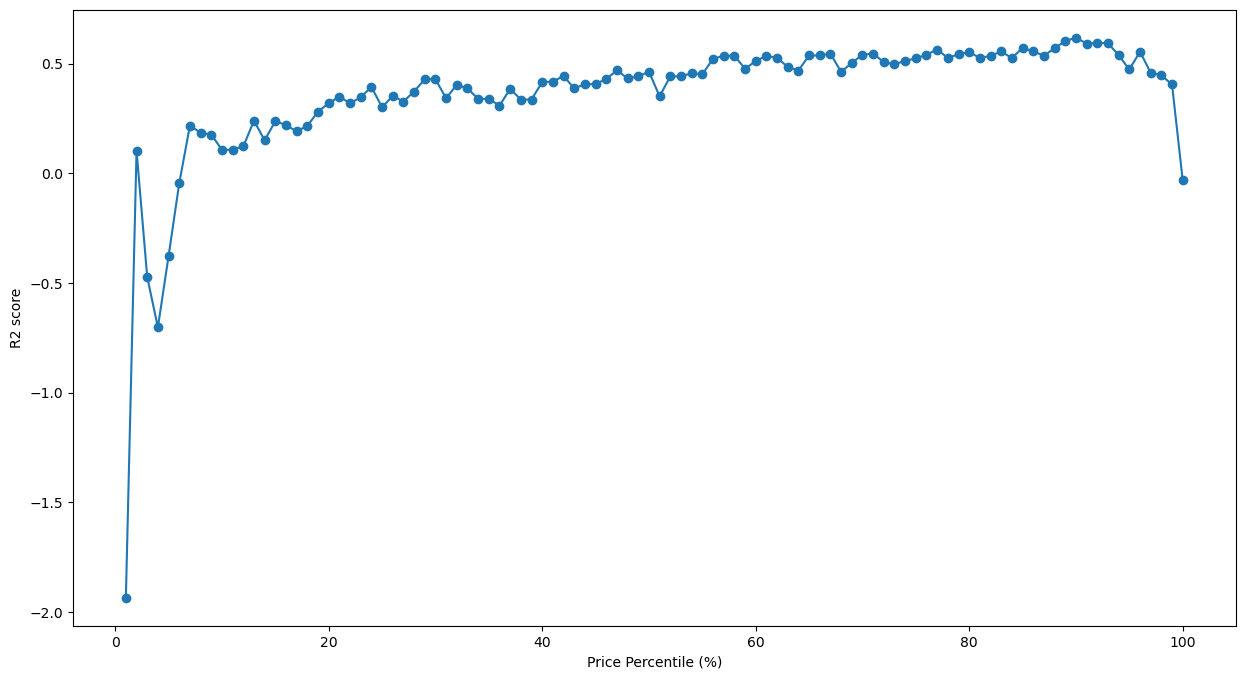

In [87]:
# Biểu đồ thể hiện sự thay đổi của R2 Score đối với Percentile của biến y

# Danh sách dữ liệu
y = r2_list

# Tạo danh sách chỉ số x tương ứng
x = index
# Vẽ biểu đồ đường
plt.figure(figsize=(15, 8))
plt.plot(x, y, marker='o')

# Thêm tiêu đề và nhãn cho các trục

plt.xlabel("Price Percentile (%)")
plt.ylabel("R2 score")

# Hiển thị biểu đồ
plt.show()

In [90]:
# Tìm ra phân vị của Price cho giá trị R2 Score lớn nhất
max_value = max(r2_list)
max_index = r2_list.index(max_value)
outlier_price = index[max_index]
print(f">> Giá trị R2 Score lớn nhất: {max_value}")
print(f">> Chỉ số của giá trị lớn nhất: {outlier_price}")

>> Giá trị R2 Score lớn nhất: 0.6178957102293088
>> Chỉ số của giá trị lớn nhất: 90



- Biểu đồ cho thấy, khi ta chọn mức Percentile 90% cho Price, mô hình cho ra kết quả R2 Score tốt nhất, nên ta sẽ ưu tiên mức 0.9 khi áp dụng để xử lý các Outliers.
- (Tương tự cho "Area" và các thuộc tính khác).

>> Tại sao lại chọn KNN để xử lý các giá trị Null ?

In [94]:
# Hàm để điền giá trị null trong một cột bằng giá trị mode
def fill_with_mode(column):
    mode = column.mode()[0]  # mode() trả về một Series, lấy giá trị đầu tiên
    return column.fillna(mode)

# Percentile
col = ('WC','PN','Area')
up_limit = raw_data.Price.quantile(0.9)
new_raw_data = raw_data.loc[((raw_data.Price<up_limit)&(raw_data.Price!=0.0))|raw_data.Price.isna()]
for i in col:
    # Giới hạn các thuộc tính khác ở mức 97%
    up_limit = new_raw_data[i].quantile(0.97)
    new_raw_data = new_raw_data.loc[((new_raw_data[i]<up_limit)&new_raw_data[i]!=0.0)|new_raw_data[i].isna()]

clean_data = new_raw_data
# Categorical Attribute
clean_data['Area'].fillna(clean_data['Area'].mean(), inplace=True)
# Điền giá trị null trong các cột "PN", "WC", "Floor" bằng giá trị mode
for col in ['PN', 'WC', 'Floor']:
    clean_data[col] = fill_with_mode(clean_data[col])
clean_data['HouseType'] = clean_data.groupby("Type")["Price"].transform("mean")
clean_data['Location'] = clean_data.groupby("district")["Price"].transform("mean")
clean_data['Legal'] = clean_data.groupby("SoSach")["Price"].transform("mean")
df = clean_data.drop(['Day','Month','Year','Type','district','SoSach','Legal'], axis = 1)
    
# Chia tập X và y
X = df.drop(['Price'],axis = 1) 
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Tạo mô hình XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
# Huấn luyện mô hình
model.fit(X_train, y_train)
# Dự đoán
y_pred = model.predict(X_test)
# Đánh giá mô hình
mse_test = mean_squared_error(y_test, y_pred)
print(">> MSE (Mean - Mode Filling):",mse_test)
print(">> MSE (KNN Filling)        :",mse4)
print(">> R2 Score (Mean - Mode Filling):",r2_score(y_test,y_pred))
print(">> R2 Score (KNN Filling)        :",r2_list[89])

>> MSE (Mean - Mode Filling): 4.1608938751128735
>> MSE (KNN Filling)        : 3.6493811602846224
>> R2 Score (Mean - Mode Filling): 0.5643383551535557
>> R2 Score (KNN Filling)        : 0.6178957102293088



- Dễ nhận thấy, khi sử dụng KNN để fill các giá trị null cho dữ liệu, mô hình cho ra kết quả R2 Score và MSE tốt hơn so với cách dùng Mean - Mode thông thường.